##### Copyright 2025 Google LLC.

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 2 - Embeddings and similarity scores

Welcome back to the Kaggle 5-day Generative AI course!

In this notebook you will use the Gemini API's embedding endpoint to explore similarity scores.

**NOTE**: The Day 1 notebook contains lots of information for getting set up with Kaggle Notebooks. If you are having any issues, please [check out the troubleshooting steps there](https://www.kaggle.com/code/markishere/day-1-prompting#Get-started-with-Kaggle-notebooks).

## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**


## Set up the SDK

In [2]:
!pip uninstall -qqy jupyterlab kfp  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

In [3]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
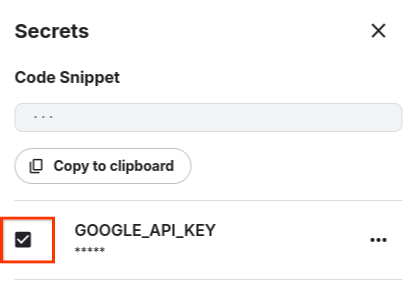

### Explore available models

You will be using the [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent) API method to calculate batch embeddings in this guide. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about the embedding models on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding).

In [5]:
client = genai.Client(api_key=GOOGLE_API_KEY)

for model in client.models.list():
  if 'embedContent' in model.supported_actions:
    print(model.name)

models/embedding-001
models/text-embedding-004
models/gemini-embedding-exp-03-07
models/gemini-embedding-exp


## Calculate similarity scores

This example embeds some variations on the pangram, `The quick brown fox jumps over the lazy dog`, including spelling mistakes and shortenings of the phrase. Another pangram and a somewhat unrelated phrase have been included for comparison.

In this task, you are going to use the embeddings to calculate similarity scores, so the `task_type` for these embeddings is `semantic_similarity`. Check out the [API reference](https://ai.google.dev/api/embeddings#v1beta.TaskType) for the full list of tasks.

In [6]:
texts = [
    'The quick brown fox jumps over the lazy dog.',
    'The quick rbown fox jumps over the lazy dog.',
    'teh fast fox jumps over the slow woofer.',
    'a quick brown fox jmps over lazy dog.',
    'brown fox jumping over dog',
    'fox > dog',
    # Alternative pangram for comparison:
    'The five boxing wizards jump quickly.',
    # Unrelated text, also for comparison:
    'Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vivamus et hendrerit massa. Sed pulvinar, nisi a lobortis sagittis, neque risus gravida dolor, in porta dui odio vel purus.',
]


response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts,
    config=types.EmbedContentConfig(task_type='semantic_similarity'))

Define a short helper function that will make it easier to display longer embedding texts in our visualisation.

In [7]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

truncated_texts = [truncate(t) for t in texts]

A similarity score of two embedding vectors can be obtained by calculating their inner product. If $\mathbf{u}$ is the first embedding vector, and $\mathbf{v}$ the second, this is $\mathbf{u}^T \mathbf{v}$. As the API provides embedding vectors that are normalised to unit length, this is also the cosine similarity.

This score can be computed across all embeddings through the matrix self-multiplication: `df @ df.T`.

Note that the range from 0.0 (completely dissimilar) to 1.0 (completely similar) is depicted in the heatmap from light (0.0) to dark (1.0).

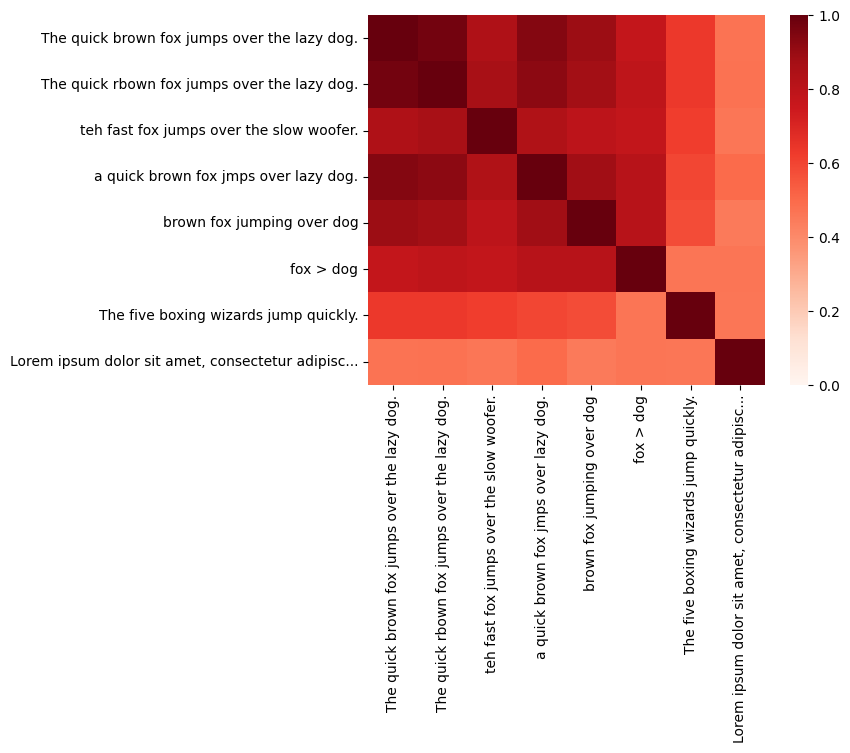

In [8]:
import pandas as pd
import seaborn as sns


# Set up the embeddings in a dataframe.
df = pd.DataFrame([e.values for e in response.embeddings], index=truncated_texts)
# Perform the similarity calculation
sim = df @ df.T
# Draw!
sns.heatmap(sim, vmin=0, vmax=1, cmap="Reds");

You can see the scores for a particular term directly by looking it up in the dataframe.

In [9]:
sim['The quick brown fox jumps over the lazy dog.'].sort_values(ascending=False)

The quick brown fox jumps over the lazy dog.          0.999999
The quick rbown fox jumps over the lazy dog.          0.975623
a quick brown fox jmps over lazy dog.                 0.939730
brown fox jumping over dog                            0.894507
teh fast fox jumps over the slow woofer.              0.842152
fox > dog                                             0.776455
The five boxing wizards jump quickly.                 0.635346
Lorem ipsum dolor sit amet, consectetur adipisc...    0.472174
Name: The quick brown fox jumps over the lazy dog., dtype: float64

Try exploring the embeddings of your own datasets, or explore those available in [Kaggle datasets](https://www.kaggle.com/datasets).

## Further reading

* Explore [search re-ranking using embeddings](https://github.com/google-gemini/cookbook/blob/main/examples/Search_reranking_using_embeddings.ipynb) with the Wikipedia API
* Perform [anomaly detection using embeddings](https://github.com/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb)

*- [Mark McD](https://linktr.ee/markmcd)*